This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/wallaroo-inference-server-tutorials/wallaroo-inference-server-cv-unet).

## Wallaroo Inference Server:  U-Net for Brain Segmentation

This notebook is used in conjunction with the [Wallaroo Inference Server Free Edition](https://docs.wallaroo.ai/wallaroo-inferencing-server/) for U-Net for Brain Segmentation.  This provides a free Wallaroo license for performing inferences through the [U-Net for Brain Segmentation](https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master) model.  The U-Net model is trained to detect lower-grade gliomas.

This tutorial demonstrates how to:

* Convert sample images of brain scans to tensor values and perform inferences through the [Wallaroo Inference Server Free Edition](https://docs.wallaroo.ai/wallaroo-inferencing-server/) for U-Net for Brain Segmentation

### Prerequisites

* A deployed Wallaroo Inference Server Free Edition with one of the following options:
  * **Wallaroo.AI U-Net for Brain MRI Segmentation - x64**
* Access via port 8080 to the Wallaroo Inference Server Free Edition.

## U-Net for Brain MRI Segmentation Model Schemas

### Inputs

The U-Net for Brain MRI Segmentation Model takes the following inputs.

| Field | Type | Description |
|---|---|---|
| `input` | Variable length *List(Float)* | Tensor in the shape (n, 3, 256, 256) float.  This is the normalized pixel values of the 640x480 color image.

### Outputs

The U-Net for Brain MRI Segmentation Model takes the following Outputs.

| Field | Type | Description |
|---|---|---|
| `output` | Variable length *List(Float)* | A flattened numpy array of detected objects.  When reshaped into a `(1, 256, 256)` returns where the bounding for a detected glioma. |

## Wallaroo Inference Server API Endpoints

The following HTTPS API endpoints are available for Wallaroo Inference Server.

### Pipelines Endpoint

* Endpoint: HTTPS GET `/pipelines`
* Returns:
  * List of `pipelines` with the following fields.
    * **id** (*String*): The name of the pipeline.
    * **status** (*String*): The pipeline status.  `Running` indicates the pipeline is available for inferences.

#### Pipeline Endpoint Example

The following demonstrates using `curl` to retrieve the Pipelines endpoint.  Replace the HOSTNAME with the address of your Wallaroo Inference Server.

In [5]:
!curl HOSTNAME:8080/pipelines

{"pipelines":[{"id":"pt-unet","status":"Running"}]}

### Models Endpoint

* Endpoint: GET `/models`
* Returns:
  * List of `models` with the following fields.
    * **name** (*String*):  The name of the model.
    * **sha** (*String*):  The `sha` hash of the model.
    * **status** (*String*):  The model status.  `Running` indicates the models is available for inferences.
    * **version** (*String*): The model version in UUID format.

#### Models Endpoint Example

The following demonstrates using `curl` to retrieve the Models endpoint.  Replace the HOSTNAME with the address of your Wallaroo Inference Server.

In [6]:
!curl HOSTNAME:8080/models

{"models":[{"name":"pt-unet","version":"5a0f70fc-e33b-487c-80c9-24e23e5621b5","sha":"dfcd4b092e05564c36d28f1dfa7293f4233a384d81fe345c568b6bb68cafb0c8","status":"Running"}]}

### Inference Endpoint

The following endpoints are available from the Wallaroo Server for Computer Vision Yolov8n deployment.

* Endpoint: HTTPS POST `/pipelines/hf-summarizer-standard`
* Headers:
  * `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
  * `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.
* Input Parameters:   The images **must** be in 256x256 format converted to a float tensor.DataFrame in `application/json; format=pandas-records` **OR** Apache Arrow table in `application/vnd.apache.arrow.file` with the shape `(n, 3, 256, 256)` then flattened, with the tensor values in the field `input`.
* Returns:
  * Headers
    * `Content-Type: application/json; format=pandas-records`: pandas DataFrame in record format.
  * Data
    * **time** (*Integer*): The time since UNIX epoch.
    * **in**:  The original input.
      * **images**:  The flattened tensor values for the original image.
    * **out**: The outputs of the inference result separated by data type.
      * **output**: The float outputs for the inference.  This list is flattened, and when reshaped into `(1, 256, 256)` that corresponds to a mask image showing the gliomas position.
    * **check_failures** (*List[Integer]*): Whether any validation checks were triggered.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing).
    * **metadata**: Additional data for the inference.
      * **last_model**:  The model used for the inference.
        * **model_name** (*String*): The name of the model used.
        * **model_sha** (*String*): The sha of the model used.
      * **pipeline_version** (*String*): The pipeline version in UUID format.
      * **elapsed** (*List[Integer]*): A list of time in nanoseconds for:
        * [0] The time to serialize the input.
        * [1...n] How long each step took.
      * **dropped** (*List*): Any dropped input tables.

### Inference Endpoint Example

The Wallaroo Inference Server accepts pandas DataFrame or Apache Arrow tables as inference inputs.  The sample file `./data/TCGA_CS_4944.png` is used as the sample input.

The following code segment demonstrates converting the image to a DataFrame.

```python

input_image = Image.open(filename)
display(input_image)

# preprocess
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

nimage = input_batch.detach().numpy()
nimage.shape
```

The following code segment demonstrates performing an inference through the Wallaroo Inference Server with the Yolov8n model deployed.  Replace `HOSTNAME`  with the hostname or IP address of your Wallaroo Inference Server instance.

In [7]:
# used to convert the Image into a numpy array
from PIL import Image
from torchvision import transforms

import pyarrow as pa
import numpy as np
import pandas as pd

import requests

# used to display dataframe information without truncating
from IPython.display import display
pd.set_option('display.max_colwidth', None)


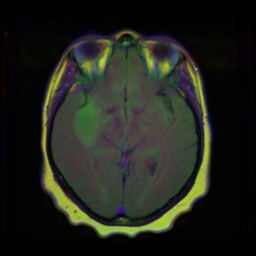

(1, 3, 256, 256)

In [37]:
filename = './data/TCGA_CS_4942_19970222_9.tif'

input_image = Image.open(filename)
display(input_image)

# preprocess
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

nimage = input_batch.detach().numpy()
nimage.shape

In [38]:
nimage = input_tensor.detach().numpy()

input_data = {
        "input": [nimage]
}
dataframe = pd.DataFrame(input_data)

In [ ]:
# turn into arrow table here



In [39]:
headers = {
        'Content-Type': 'application/json; format=pandas-records'
    }
# 

deploy_url = 'http://testboy.local:8080/pipelines/pt-unet'

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=dataframe.to_json(orient="records")
                )

# display(pd.DataFrame(response.json()).loc[0, 'out']['output'][0][0][0:5])

# convert the image back to a dataframe

image_flat_tensors = pd.DataFrame(response.json()).loc[0, 'out']['output']
image_flat_tensors[0][0][0:5]

[1.42915e-05, 1.4762122e-05, 1.4074442e-05, 1.3313269e-05, 1.4010605e-05]

In [ ]:
# turn into curl with dataframe

In [ ]:
# turn into curl with arrow table